In [47]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import savgol_filter
%matplotlib inline

In [48]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [49]:
disp_figs = True

In [50]:
M = 4 # Number of Spiking motifs
N = 10 # Number of input neurons
D = 31 # temporal depth of receptive field
T = 1000
dt = 1
nrn_fr = 40 # hz
pg_fr = 4 # hz
background_noise_fr = 0 # h

np.random.seed(40)

In [51]:
# for matplotlib
colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
len(colors)

10

# Generate the PG Kernels


In [52]:
# I will try and do this with dense and sparse representations at the same time
# Dense K: matrix of binary images of sizeNxDxM
# Sparse K: set of (delay d, neuron a, and pg b)

K_dense = np.random.randint(0,999,(N,D,M))
K_dense[K_dense < nrn_fr] = 1
K_dense[K_dense >= nrn_fr] = 0
K_sparse = np.where(K_dense)

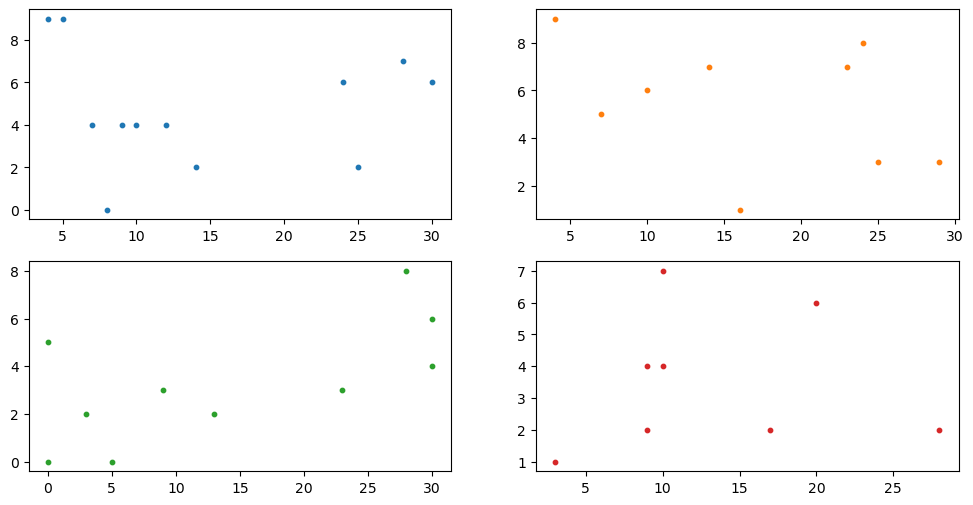

In [53]:

if disp_figs:
    %matplotlib inline
    fig,ax = plt.subplot_mosaic('AB;CD',figsize=(12,6))
    [ax[k].scatter(K_sparse[1][K_sparse[2]==i], K_sparse[0][K_sparse[2]==i],c=colors[i],s=10) for i,k in enumerate(['A','B','C','D'])]

# Generate the PG occurrences


In [54]:
# I suppose I can also do this in sparse and dense
# dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
# spare B: set of all times t and pg's b
B_dense = np.random.randint(0,999,(M,T))
B_dense[B_dense < pg_fr] = 1
B_dense[B_dense >= pg_fr] = 0
B_sparse = np.where(B_dense)

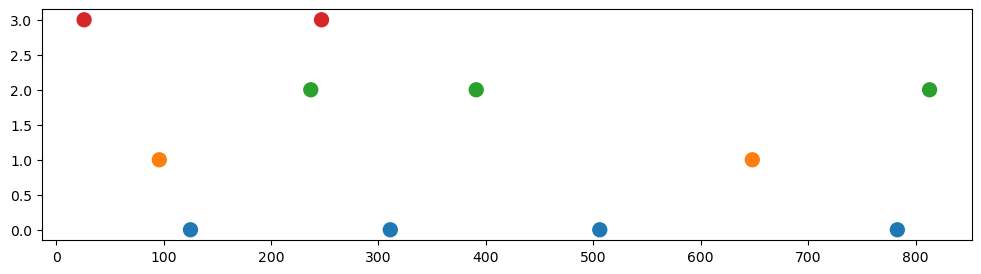

In [55]:
plt.figure(figsize=(12,3))
plt.scatter(B_sparse[1],B_sparse[0],c=colors[B_sparse[0]],s=100)
plt.show()

# Convolve the PG kernels with the PG firing times

In [56]:
# now to make the full raster plot keeping the labels in-tact
# dense A: the layered binary images of all neuron spikes by PG ( N x T x M
A_dense = np.zeros((N,T+D,M+1))
A_dense[...,-1] = np.random.randint(0,999,(N,T+D))
A_dense[...,-1] = (A_dense[...,-1] < background_noise_fr).astype('int')
for i in range(len(B_sparse[0])):
    t = B_sparse[1][i]
    b = B_sparse[0][i]
    A_dense[:, t:t+D, b] += K_dense[...,b]
    
A_dense.shape
# A_dense = A_dense[:,:1000,:]
A_sparse = np.where(A_dense)
A_dense = np.sum(A_dense,axis=2)
A_dense[A_dense>1] = 1
A_dense.shape

(10, 1031)

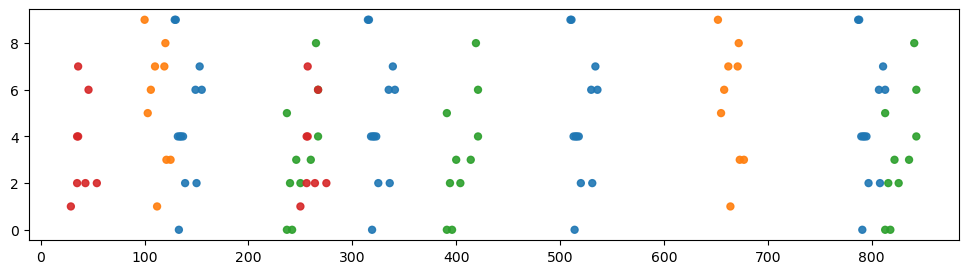

In [57]:
%matplotlib inline
plt.figure(figsize=(12,3))
plt.scatter(A_sparse[1],A_sparse[0],c=colors[A_sparse[2]],alpha=0.9,s=100,marker='.')
plt.show()

# Sanity Check

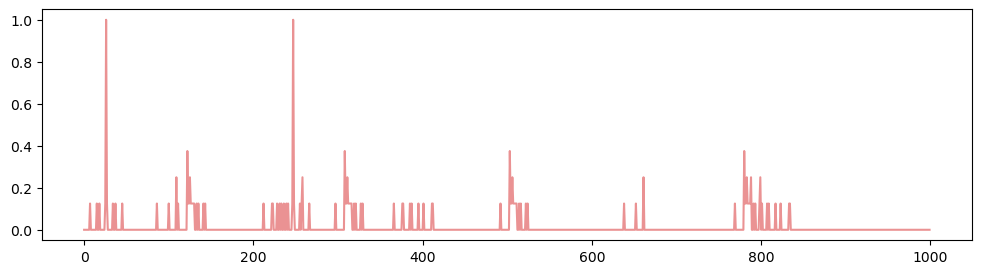

In [58]:
test = np.zeros((T,M))
%matplotlib inline
for j in range(M):
    for i in range(T):
        test[i,j] = np.sum(K_dense[...,j]*A_dense[:,i:i+D])
    test[:,j] = test[:,j]/np.max(test[:,j])
plt.figure(figsize=(12,3))
i = 3
plt.plot(test[:,i],color=colors[i],alpha=0.5)

# Windowing the data

In [59]:
test_row = 0

In [60]:
window_dim = (int(np.ceil(D/2)), N)
valid_spikes = (A_sparse[1] > window_dim[0]) & (A_sparse[1] < T- window_dim[0])

In [61]:
M_labels = A_sparse[2][valid_spikes]
N_labels = A_sparse[0][valid_spikes]
T_labels = A_sparse[1][valid_spikes]
windows = np.zeros((len(T_labels), N, window_dim[0]*2))
for i,window_time in enumerate(T_labels):
    windows[i,...] = A_dense[:,-window_dim[0]+window_time:window_dim[0]+window_time]
#     windows[i,N_labels[i],window_dim[0]] = 2
print('spikes: %d, neurons: %s, depth: %a' %windows.shape)

spikes: 112, neurons: 10, depth: 32


In [62]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [63]:
HDPs = []
sim_mats = []
# Set the cutoff value for clustering
cutoff = 1

# Get the cluster assignments for each spike based on the hierarchical clustering
clusters = []
for n in range(N):
    test = windows[N_labels==n]
    x = np.zeros((len(test),len(test)))
    for i in range(test.shape[0]):
        for j in range(test.shape[0]):
            x[i,j] = np.sum(test[i]*test[j])/ min(np.sum(test[i]),np.sum(test[j]))
    sim_mats.append(x)
    dissimilarity = 1 - x
    HDPs.append(linkage(dissimilarity, method='complete'))
    clusters += list((n*10)+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance'))

clusters= np.array(clusters)

C:\Users\miles\AppData\Local\Temp\ipykernel_10312\3563588383.py:16: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  HDPs.append(linkage(dissimilarity, method='complete'))
C:\Users\miles\AppData\Local\Temp\ipykernel_10312\3563588383.py:17: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters += list((n*10)+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance'))


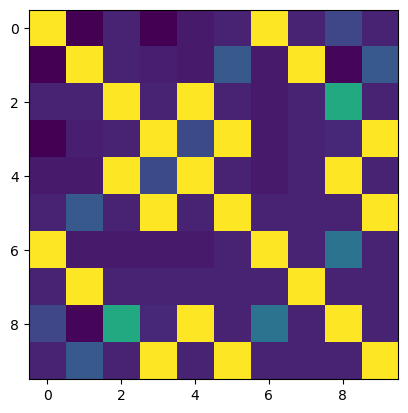

In [64]:
plt.figure()
plt.imshow(sim_mats[3])

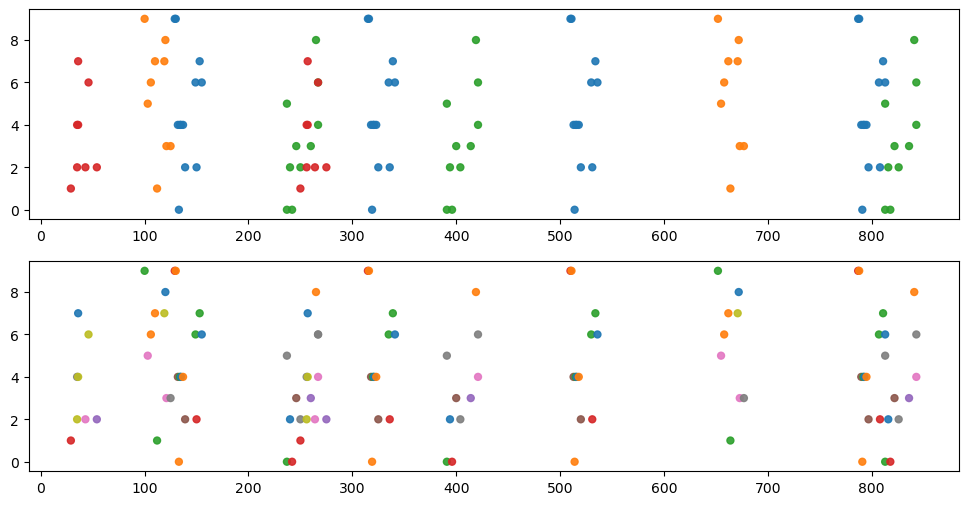

In [65]:
%matplotlib inline
fig,ax = plt.subplot_mosaic('A;B',figsize=(12,6))
ax['A'].scatter(A_sparse[1],A_sparse[0],c=colors[A_sparse[2]],alpha=0.9,s=100,marker='.')
ax['B'].scatter(A_sparse[1],A_sparse[0],c=colors[clusters%9],alpha=0.9,s=100,marker='.')
plt.show()

In [66]:
time_differences = []
cluster_sq = {}
for cluster in np.unique(clusters):
    time_differences.append(list(np.diff(A_sparse[1][clusters == cluster])))
    if str(list(np.diff(A_sparse[1][clusters == cluster]))) in cluster_sq.keys():
        cluster_sq[str(list(np.diff(A_sparse[1][clusters == cluster])))] = cluster_sq[str(list(np.diff(A_sparse[1][clusters == cluster])))] + [cluster]
    else: 
        cluster_sq[str(list(np.diff(A_sparse[1][clusters == cluster])))] = [cluster]
        
new_labels = clusters.copy()
for l, key in enumerate(cluster_sq.keys()):
    for k in cluster_sq[key]:
        new_labels[new_labels == k] = l

import numpy as np
from scipy.optimize import linear_sum_assignment

# Given arrays
labels_array_1 = new_labels.copy()

labels_array_2 = A_sparse[2].copy()

for l in np.unique(labels_array_1):
    if l not in labels_array_2:
        labels_array_2[labels_array_1 == l] = l

# Get unique labels from both arrays
unique_labels_1 = np.unique(labels_array_1)
unique_labels_2 = np.unique(labels_array_2)

# Create a cost matrix where each entry represents the cost of matching two labels
cost_matrix = np.zeros((len(unique_labels_1), len(unique_labels_2)))

for i, label_1 in enumerate(unique_labels_1):
    for j, label_2 in enumerate(unique_labels_2):
        common_elements = np.logical_and(labels_array_1 == label_1, labels_array_2 == label_2)
        cost_matrix[i, j] = -np.sum(common_elements)

# Use the Hungarian algorithm to find the optimal mapping
row_indices, col_indices = linear_sum_assignment(cost_matrix)

# Create a mapping dictionary from the optimal mapping
mapping_dict = {unique_labels_1[i]: unique_labels_2[j] for i, j in zip(row_indices, col_indices)}

# Map the labels from labels_array_1 to labels_array_2 using the mapping dictionary
mapped_labels = np.array([mapping_dict[label] for label in labels_array_1])

print(mapped_labels)


[0 2 2 0 2 2 0 0 2 2 3 1 3 1 3 3 3 0 0 2 2 3 3 3 0 0 2 2 0 0 0 0 2 2 1 1 2
 2 2 2 1 1 2 2 3 3 0 0 0 0 3 3 2 0 0 0 0 2 0 0 0 0 0 0 0 0 2 1 2 2 1 2 5 1
 0 0 4 4 0 0 4 0 0 1 0 0 4 3 1 1 0 3 0 0 1 1 0 1 2 2 1 2 1 0 0 0 0 0 0 1 0
 0]


In [67]:
A_sparse[2]

array([0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 3, 1, 3, 1, 3, 3, 3, 0, 0, 2, 2, 3,
       3, 3, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2,
       3, 3, 0, 0, 0, 0, 3, 3, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 1, 2, 2, 1, 2, 3, 1, 0, 0, 2, 3, 0, 0, 2, 0, 0, 1, 0, 0, 2, 3,
       1, 1, 0, 3, 0, 0, 1, 1, 0, 1, 2, 2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0], dtype=int64)

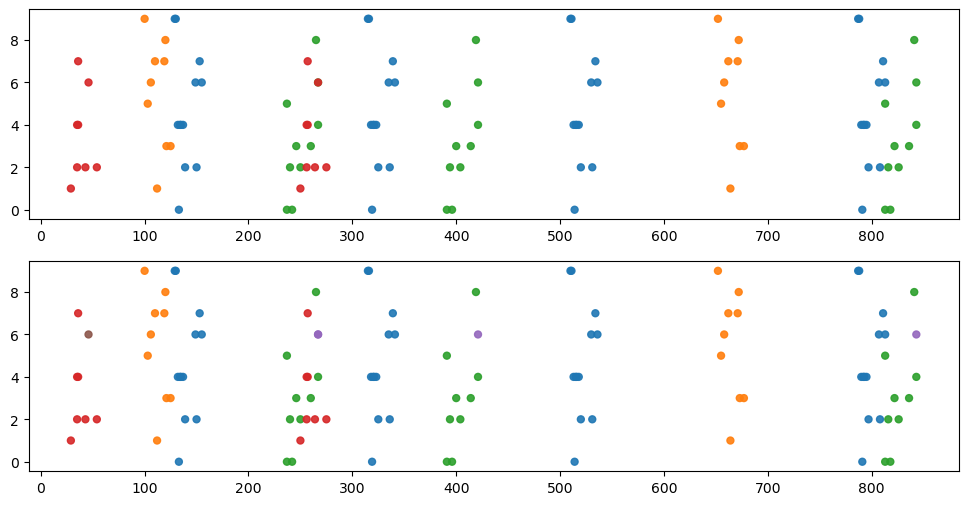

In [68]:
%matplotlib inline
fig,ax = plt.subplot_mosaic('A;B',figsize=(12,6))
ax['A'].scatter(A_sparse[1],A_sparse[0],c=colors[A_sparse[2]],alpha=0.9,s=100,marker='.')
ax['B'].scatter(A_sparse[1],A_sparse[0],c=colors[mapped_labels],alpha=0.9,s=100,marker='.')
plt.show()

In [75]:
accuracy = np.sum(A_sparse[2]==mapped_labels)/len(A_sparse[2])
accuracy

0.9553571428571429

In [70]:
A_sparse[1]

array([133, 237, 242, 319, 391, 396, 514, 791, 813, 818,  29, 112, 250,
       664,  35,  43,  54, 139, 150, 240, 250, 256, 264, 275, 325, 336,
       394, 404, 520, 531, 797, 808, 816, 826, 121, 125, 246, 260, 400,
       414, 673, 677, 822, 836,  35,  36, 132, 134, 135, 137, 256, 257,
       267, 318, 320, 321, 323, 421, 513, 515, 516, 518, 790, 792, 793,
       795, 843, 103, 237, 391, 655, 813,  46, 106, 149, 155, 267, 267,
       335, 341, 421, 530, 536, 658, 807, 813, 843,  36, 110, 119, 153,
       257, 339, 534, 662, 671, 811, 120, 265, 419, 672, 841, 100, 129,
       130, 315, 316, 510, 511, 652, 787, 788], dtype=int64)

In [71]:
clusters[A_sparse[0]==1]

array([12, 11, 12, 11])

In [72]:
A_sparse[2][A_sparse[0]==1]

array([3, 1, 3, 1], dtype=int64)

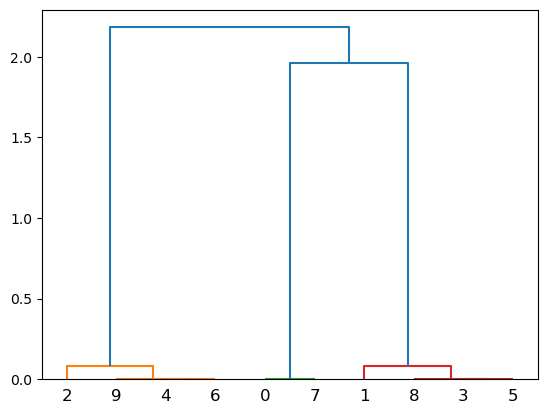

In [73]:
dn = dendrogram(HDPs[9])

In [ ]:
from scipy.cluster.hierarchy import fcluster

# Set the cutoff value for clustering
cutoff = 1

# Get the cluster assignments for each spike based on the hierarchical clustering
clusters = fcluster(debug, cutoff, criterion='distance')

In [60]:
A_sparse[1][A_sparse[0]==3]

array([143, 143, 144, 150, 247, 252, 395, 396, 402, 433, 434, 440, 451,
       467, 474, 565, 566, 572, 718, 719, 725, 733, 738, 767, 772, 805],
      dtype=int64)